# PCA on UKBB Meshes

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import pyvista as pv

from coma.datasets.ukbb_meshdata import UKBBMeshDataset
from coma.utils import transforms
from coma.utils.decomposition import PCAShapeModel3D
from coma.utils.visualise import plot_single_mesh, plot_mesh

In [3]:
%aimport coma.utils.decomposition

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [5]:
brain_substructure = 'BrStem'

In [6]:
%%bash
ls "/vol/bitbucket/rrr2417/deepscm_data_cache"

data_subject_ids_Br_Stem.pickle
data_subject_ids_BrStem.pickle
data_subject_ids_R_Hipp.pickle
flat_list_Br_Stem.pickle
flat_list_BrStem.pickle
flat_list_R_Hipp.pickle
lookup_dict_Br_Stem.pickle
lookup_dict_BrStem.pickle
lookup_dict_R_Hipp.pickle


In [7]:
# Preprocessor
preprocessor = transforms.get_transforms()

# Load Dataset
mesh_path = "/vol/biomedic3/bglocker/brainshapes"
cache_path = "/vol/bitbucket/rrr2417/deepscm_data_cache"
csv_path = "/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv"
split = 0.8

substructure_to_udi = {
    'BrStem': '25025-2.0', 
    'L_Thal': '25011-2.0',
    'L_Caud': '25013-2.0',
    'L_Puta': '25015-2.0',
    'L_Pall': '25017-2.0',
    'L_Hipp': '25019-2.0',
    'L_Amyg': '25021-2.0',
    'L_Accu': '25023-2.0',
    'R_Thal': '25012-2.0',
    'R_Caud': '25014-2.0',
    'R_Puta': '25016-2.0',
    'R_Pall': '25018-2.0',
    'R_Hipp': '25020-2.0',
    'R_Amyg': '25022-2.0',
    'R_Accu': '25024-2.0',
}

feature_name_map = {
    '31-0.0': 'sex',
    '21003-0.0': 'age',
    substructure_to_udi[brain_substructure]: 'structure_volume',  # Brain Stem
    '25010-2.0': 'brain_volume',  # Unnormalised brain volume from UKBB
}

metadata_df = pd.read_csv(csv_path)

total_train_dataset = UKBBMeshDataset(
    mesh_path,
    substructures=[brain_substructure],
    split=split,
    train=True,
    transform=preprocessor,
    reload_path=True,
    features_df=metadata_df,
    feature_name_map=feature_name_map,
    cache_path=cache_path,
)

/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (255,273,274,275,279,351,451,452,453,454,1344,1347,1350,1351,1352,1396,1397,1398,1399,1400,1401,1402,1428,1429,1430,1431,1432,1433,1434,1492,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1968,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2431) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
len(total_train_dataset)

11601

In [9]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

In [10]:
data = [total_train_dataset[i] for i in range(5000)]
meshes = torch.cat([mesh for (mesh, _) in data], 0).detach().numpy()
print(meshes.shape)
features = pd.concat([df for (_, df) in data], 0)
print(features.shape)
features.head()

(5000, 642, 3)
(5000, 5)


eid  sex  age  structure_volume  brain_volume
4367   1000596    1   54             30672       1331850
10908  1000811    1   46             24685       1255420
829    1000845    1   54             24183       1155230
4846   1001078    1   62             24390       1200210
2299   1001494    1   49             22527       1329680

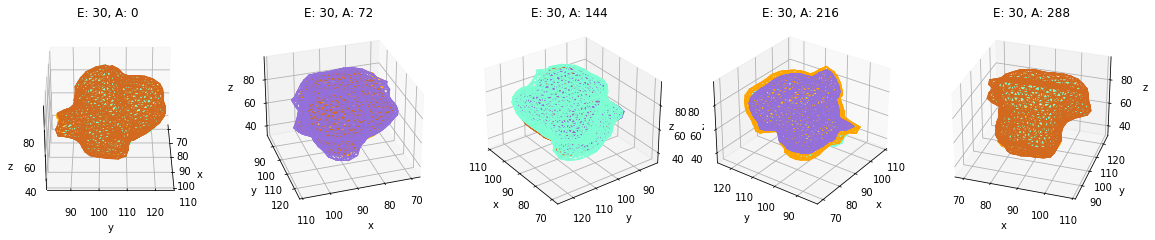

In [11]:
labels = ['+ve', 'mean', '-ve']
coma.utils.visualise.plot_wireframes(meshes[0:3], faces, elevations=[30], azimuths=5, labels=labels)

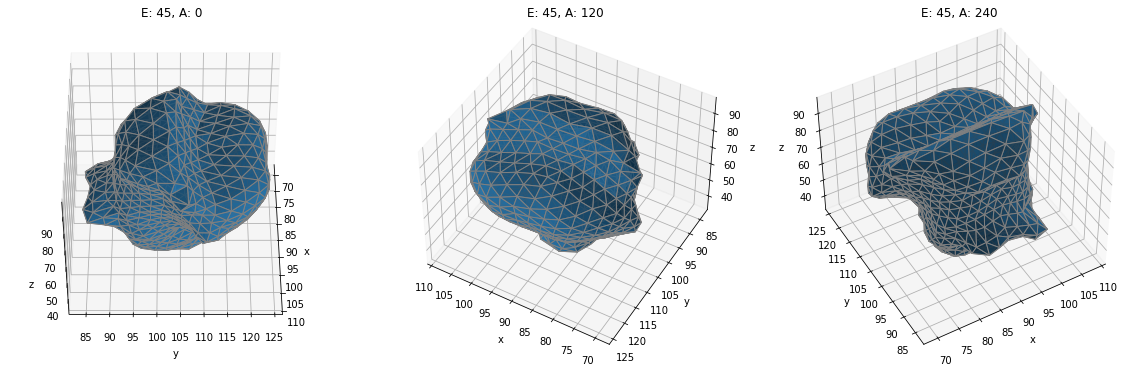

In [12]:
plot_mesh(meshes[0], faces, figsize=(20, 10), elevations=[45], azimuths=3)

## Shape Modelling

In [13]:
%aimport coma.utils.visualise

In [14]:
shape_model = coma.utils.decomposition.PCAShapeModel3D()
shape_model.fit(meshes)

### PCA Shape Model

Mode: 1


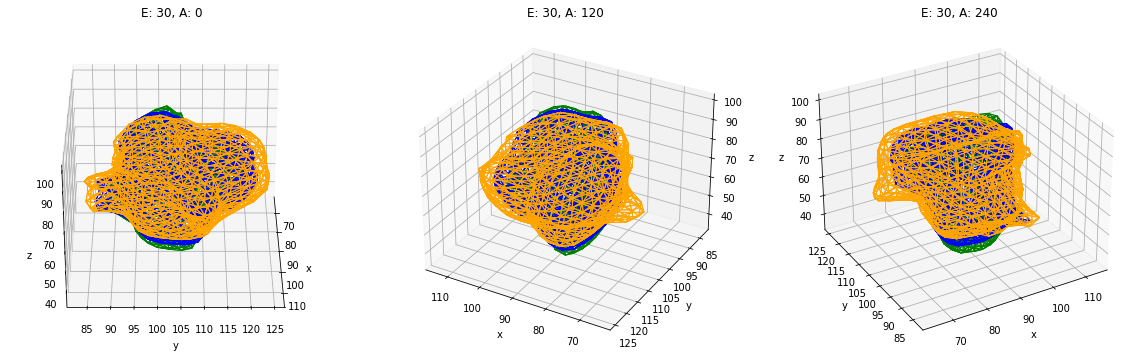

Mode: 2


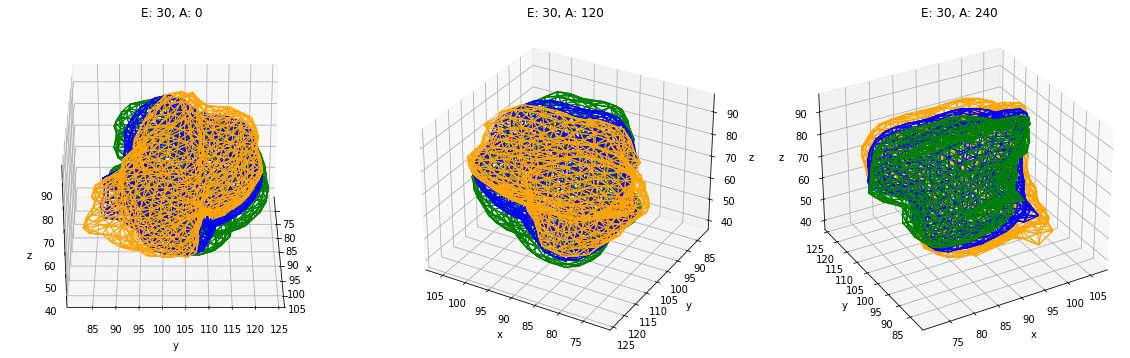

Mode: 3


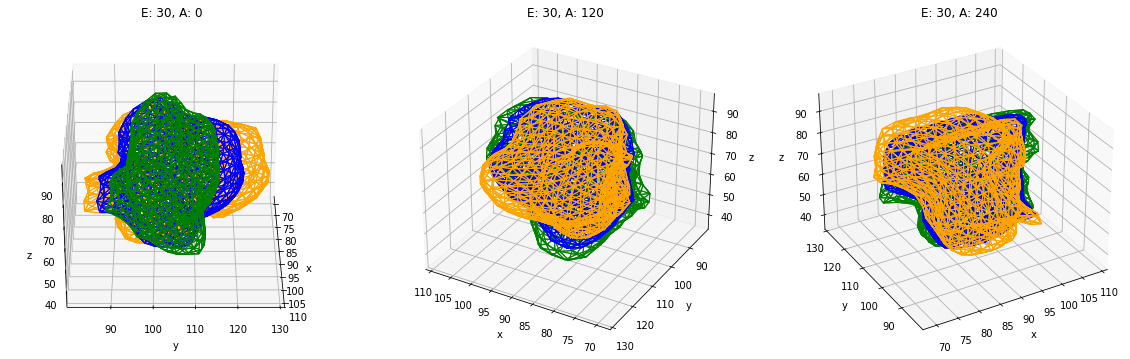

Mode: 4


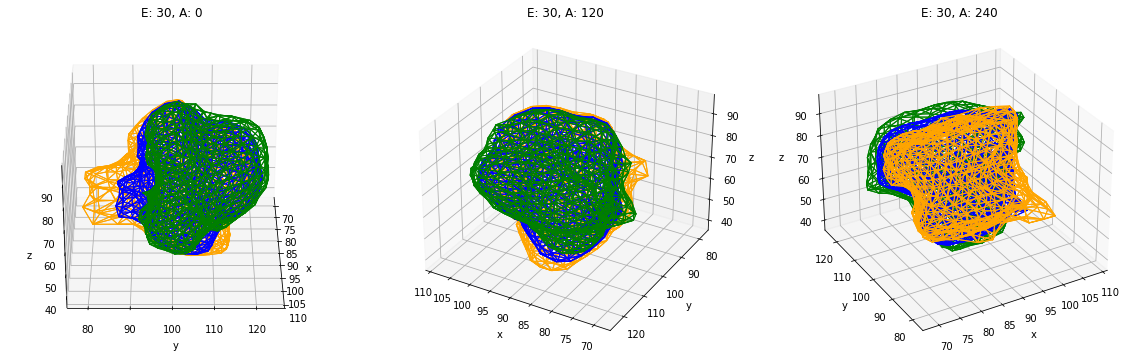

Mode: 5


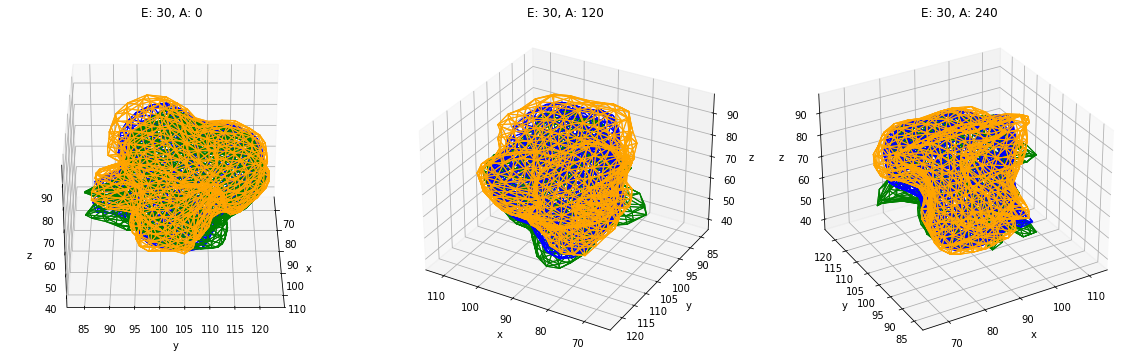

Mode: 6


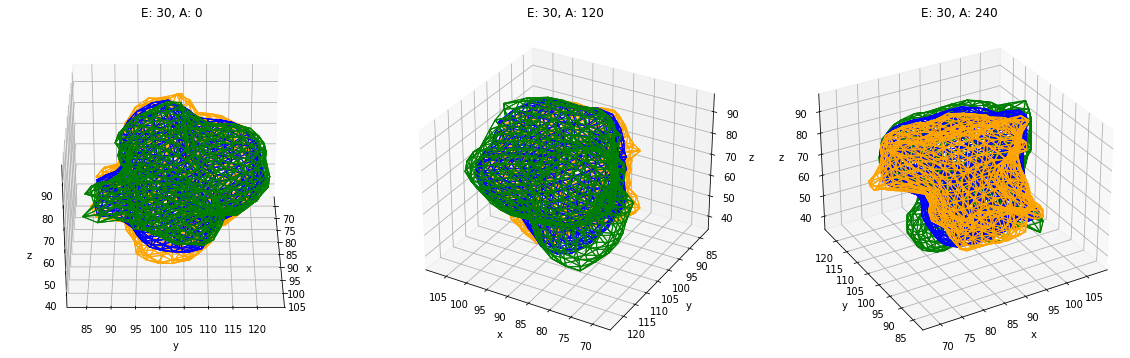

Mode: 7


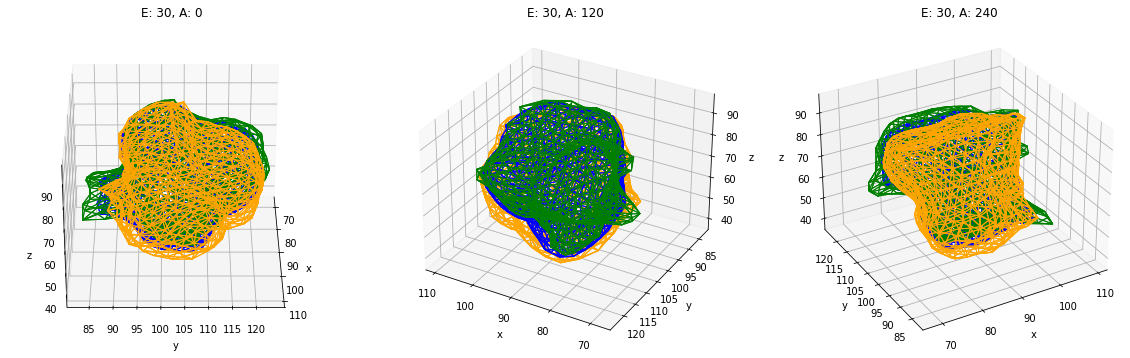

Mode: 8


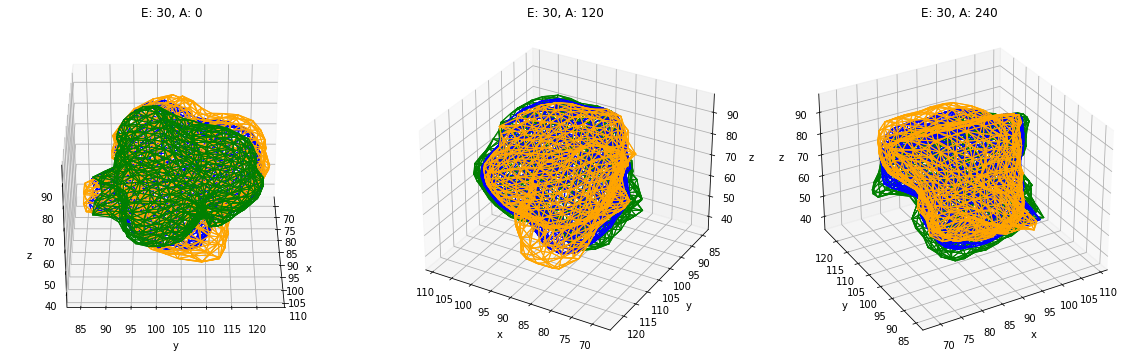

Mode: 9


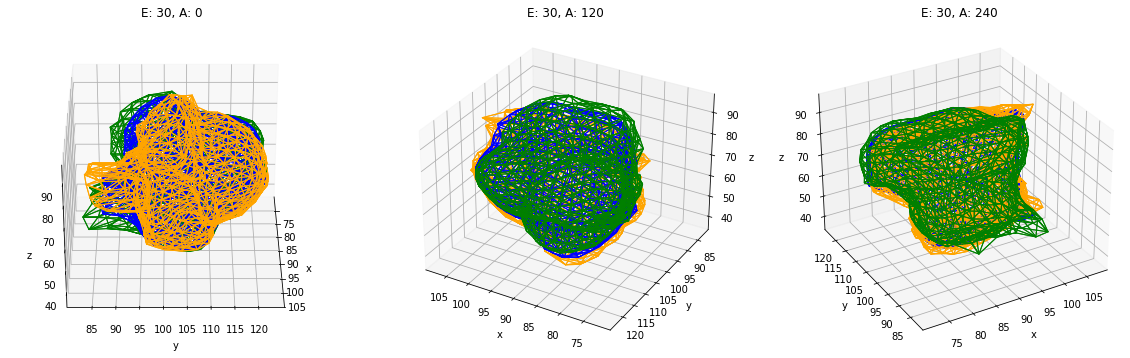

Mode: 10


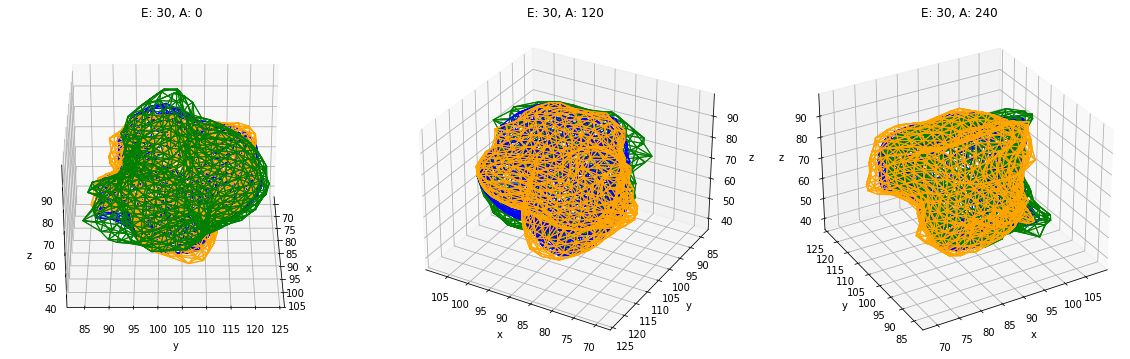

Mode: 11


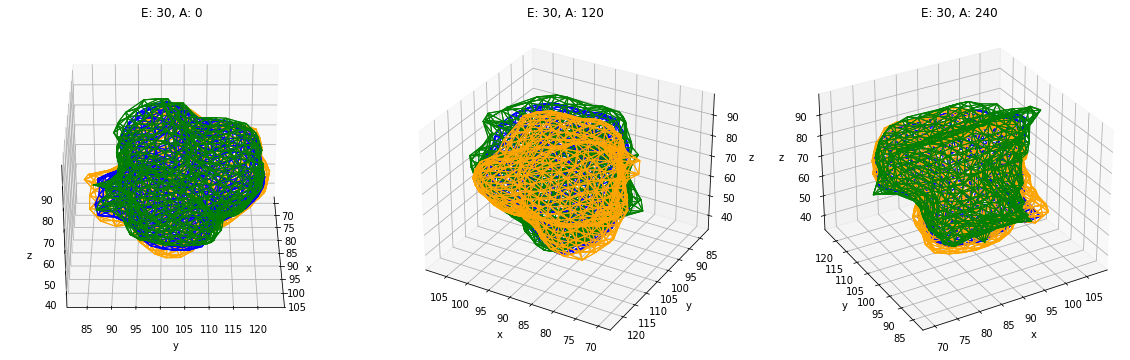

Mode: 12


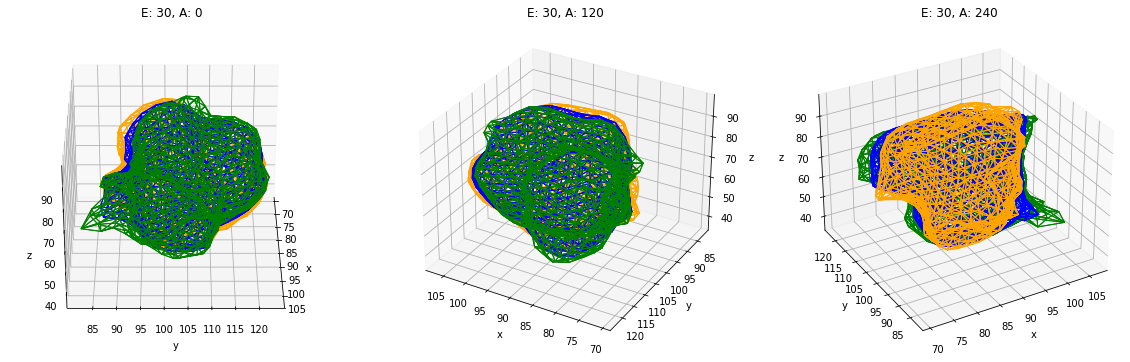

Mode: 13


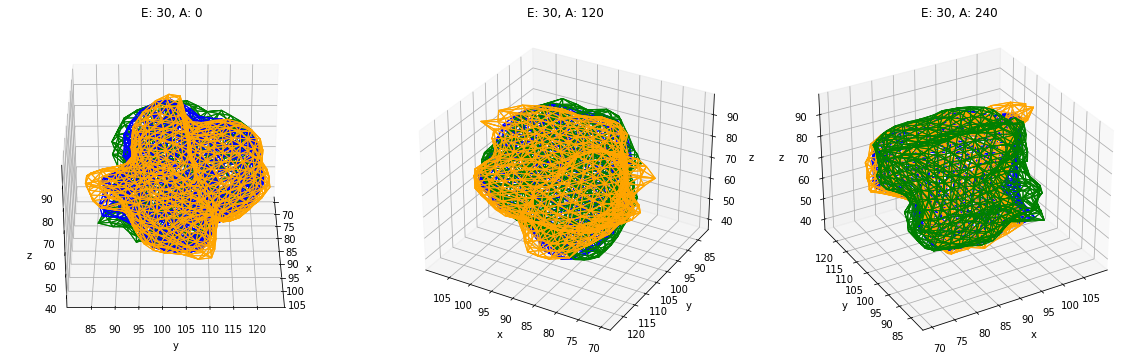

Mode: 14


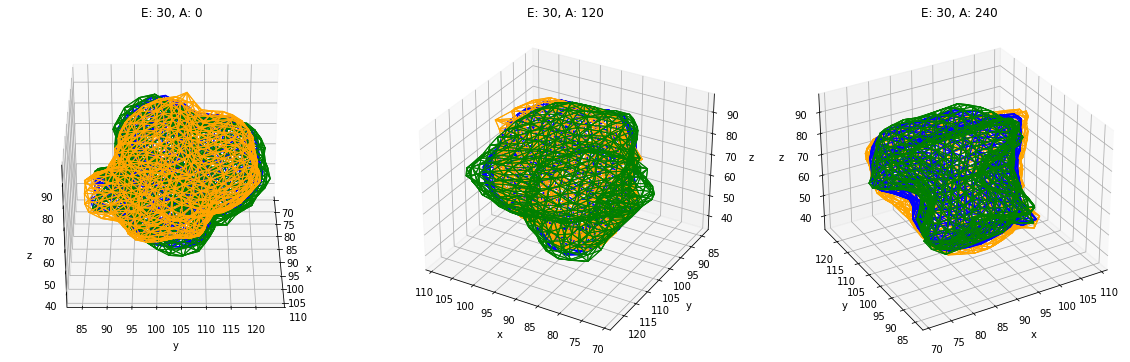

Mode: 15


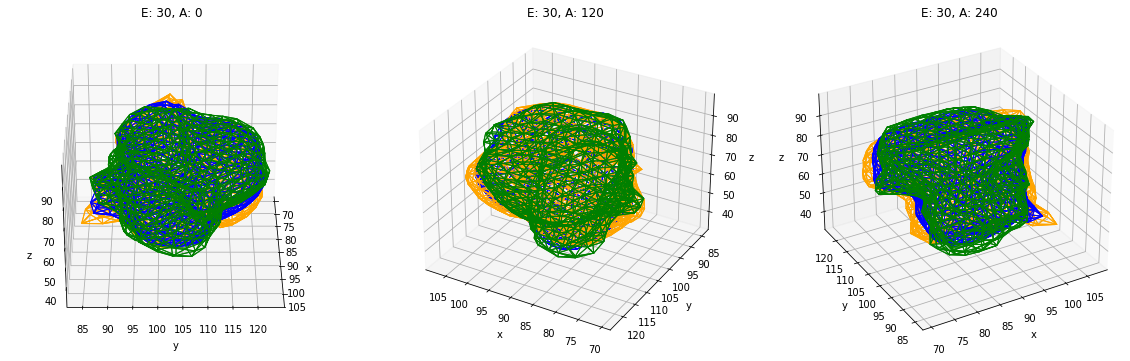

Mode: 16


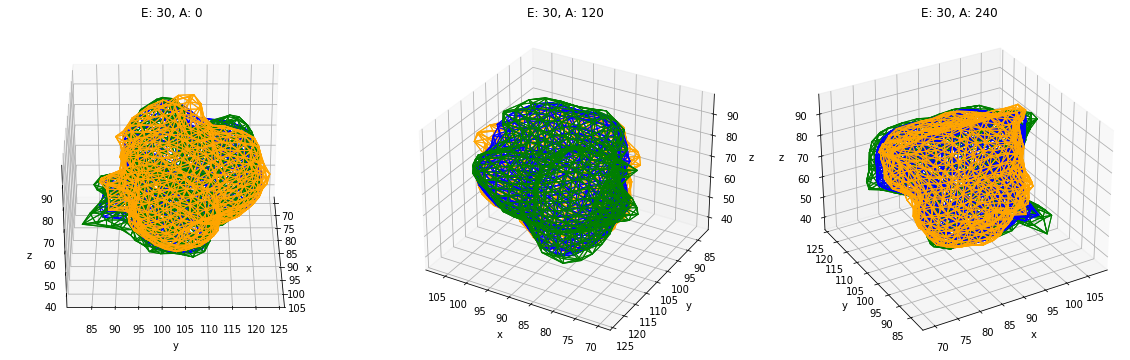

Mode: 17


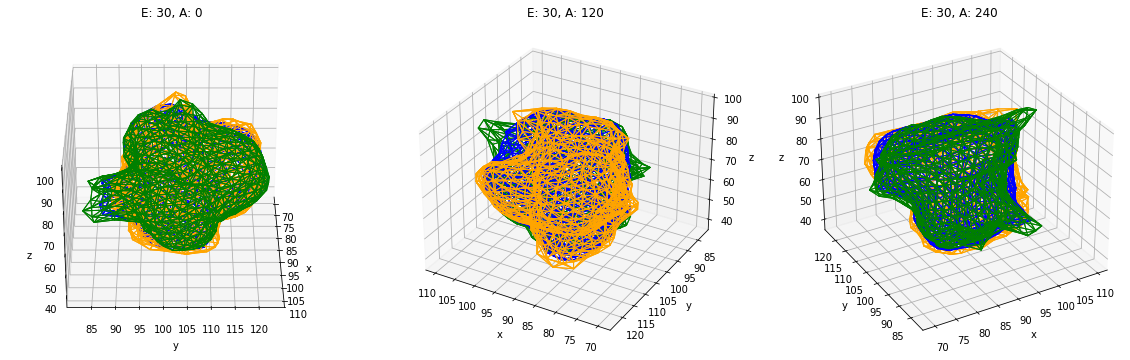

Mode: 18


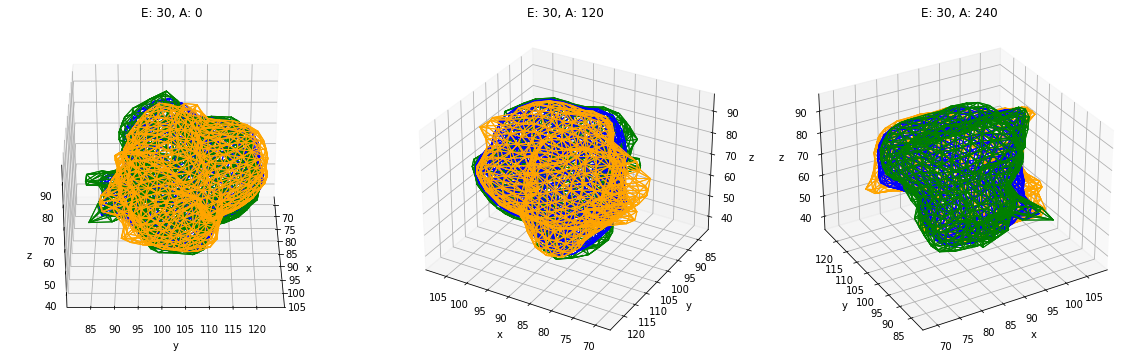

Mode: 19


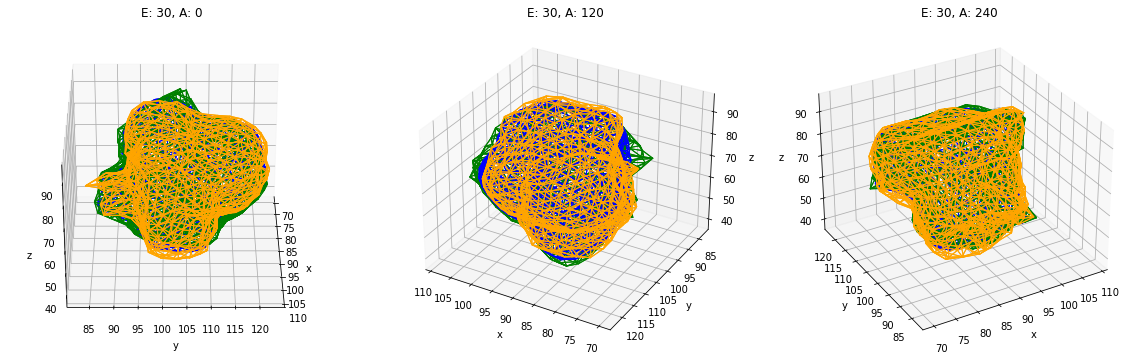

Mode: 20


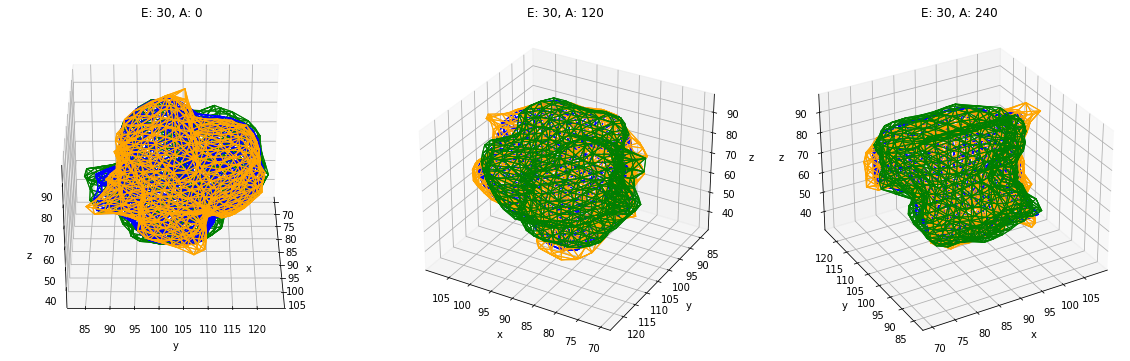

In [15]:
for mode in range(1, 21):
    print(f'Mode: {mode}')
    (mode_1_pos, mode_1_neg) = shape_model.mode(mode, 3)
    mode_1 = np.concatenate([
        np.expand_dims(mode_1_pos, 0),
        np.expand_dims(shape_model.mean, 0),
        np.expand_dims(mode_1_neg, 0),
    ])
    edge_colors = ['orange', 'blue', 'green']
    labels = ['+ve', 'mean', '-ve']
    coma.utils.visualise.plot_wireframes(
        mode_1,
        faces,
        elevations=[30],
        azimuths=3,
        edge_colors=edge_colors,
        labels=labels,
    )

### LDA Shape Model - gender conditional

LDA - to find a projection matrix W, with eigenvectors that are the dimensions of a subspace in which the data preserves variance (i.e. the range of a variation in a visible feature) and but also allows classes to be separated. So by visualising the eigenvectors, which make up the linear projection matrix in LDA, we can see which features maintain the generalise brain shape in the standard basis, as opposed ot noise, but also enable us to discriminate between a choosen class, i.e. by viewing an LDA shape model, we see the modes along which we can discriminate between multiple classes.

Non-linear LDA - non-linear modes?

In [ ]:
shape_model = coma.utils.decomposition.LDAShapeModel3D()
shape_model.fit(meshes, features.sex.values)

0
(2607, 1926)


In [ ]:
explained_var = shape_model.eigenvalues[:1000].cumsum() / shape_model.eigenvalues[:1000].sum()

In [ ]:
explained_var[:50]

In [ ]:
shape_model = coma.utils.decomposition.LDAShapeModel3D()
shape_model.fit(meshes, features.age.values)

In [ ]:
shape_model.eigenvalues.argsort()

In [ ]:
explained_var = shape_model.eigenvalues[:1000].cumsum() / shape_model.eigenvalues[:1000].sum()

In [ ]:
explained_var[:50]

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(meshes.reshape(meshes.shape[0], -1), features.age.values)

In [ ]:
lda.explained_variance_ratio_

In [ ]:
lda.scalings_.shape

In [ ]:
lda.means_.shape

In [ ]:
shape_model.eigenvalues[-1]

In [ ]:
# TODO: double check if sqrt is necesary for LDA singular values
shape_model.eigenvectors[-1].reshape(642, 3) * np.sqrt(shape_model.eigenvalues[-1])

In [ ]:
lda.scalings_.shape

In [ ]:
lda.xbar_.reshape(-1, 3)

In [ ]:
for mode in range(0, 10):
    print(f'Mode: {mode}')
    # (mode_1_pos, mode_1_neg) = shape_model.mode(mode, 100)
    mode_1_pos = lda.xbar_.reshape(-1, 3) + lda.scalings_[:, mode].reshape(-1, 3) # shape_model.eigenvectors[:, mode].reshape(-1, 3)
    # mode_1_pos = np.expand_dims(mode_1_pos, 0)
    
    mean = lda.xbar_.reshape(-1, 3)
    
    mode_1_neg = lda.xbar_.reshape(-1, 3) - lda.scalings_[:, mode].reshape(-1, 3) # shape_model.eigenvectors[:, mode].reshape(-1, 3)
    # mode_1_neg = np.expand_dims(mode_1_pos, 0)
    
    print(mode_1_pos)
    print(mean)
    print(mode_1_neg)
    
    mode_1 = np.concatenate([
        np.expand_dims(mode_1_pos, 0),
        np.expand_dims(mean, 0),
    ])
    #    np.expand_dims(mode_1_neg, 0),
    #])
    edge_colors = ['orange', 'blue'] # , 'green']
    labels = ['+ve', 'mean'] # , '-ve']
    coma.utils.visualise.plot_wireframes(
        mode_1,
        faces,
        elevations=[30],
        azimuths=3,
        edge_colors=edge_colors,
        labels=labels,
    )

## Finding feature-preserving separation boundaries

In [14]:
pca_shape_model = coma.utils.decomposition.PCAShapeModel3D()
pca_shape_model.fit(meshes)

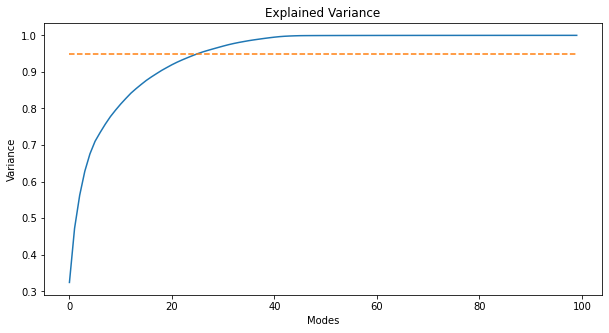

In [15]:
N = 100
plt.figure(figsize=(10, 5))
plt.title('Explained Variance')
plt.xlabel('Modes')
plt.ylabel('Cumulative Variance')
plt.plot(range(0, N), pca_shape_model.explained_variance_ratio.cumsum()[:N])
plt.plot(range(0, N), [0.95] * N, '--')
plt.show()

In [46]:
proj_meshes = pca_shape_model.project(meshes, dim=40)

### LDA on 3D meshes

In [50]:
lda_shape_model_sex = coma.utils.decomposition.LDAShapeModel3D()
lda_shape_model_sex.fit(meshes, features.sex.values)

Class: 0
Class: 1


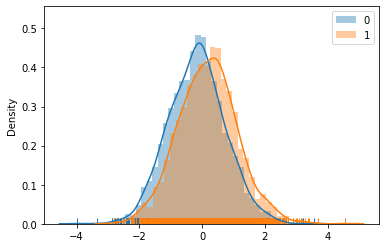

In [51]:
import seaborn as sns

lda_proj_meshes = lda_shape_model_sex.project(meshes, dim=1)

lda_proj_sex_0 = lda_proj_meshes[features.sex.values == 0]
lda_proj_sex_1 = lda_proj_meshes[features.sex.values == 1]

sns.distplot(lda_proj_sex_0, rug=True, label='0')
sns.distplot(lda_proj_sex_1, rug=True, label='1')
plt.legend()
plt.show()

In [52]:
lda_shape_model_age = coma.utils.decomposition.LDAShapeModel3D()
lda_shape_model_age.fit(meshes, features.age.values)

Class: 40
Class: 41
Class: 42
Class: 43
Class: 44
Class: 45
Class: 46
Class: 47
Class: 48
Class: 49
Class: 50
Class: 51
Class: 52
Class: 53
Class: 54
Class: 55
Class: 56
Class: 57
Class: 58
Class: 59
Class: 60
Class: 61
Class: 62
Class: 63
Class: 64
Class: 65
Class: 66
Class: 67
Class: 68
Class: 69
Class: 70


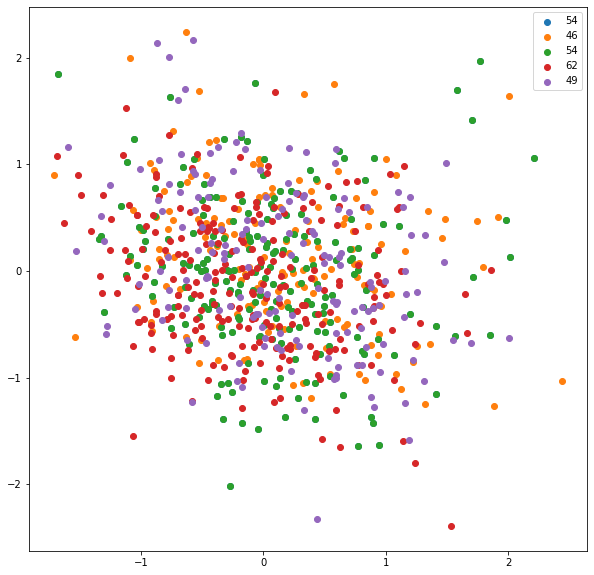

In [53]:
plt.figure(figsize=(10, 10))

lda_proj_meshes_age = lda_shape_model_age.project(meshes, dim=2)

for age in features.age.values[:5]:
    lda_proj_age = lda_proj_meshes_age[features.age.values == age]
    plt.scatter(lda_proj_age[:, 0], lda_proj_age[:, 1], label=age)

plt.legend()
plt.show()

### LDA on PCA projected meshes

#### Sex

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_sklearn_sex = LinearDiscriminantAnalysis()
lda_sklearn_sex.fit(proj_meshes, features.sex.values)
lda_sklearn_sex_proj = lda_sklearn_sex.transform(proj_meshes)

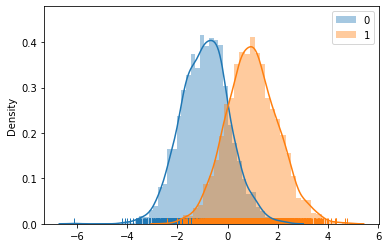

In [57]:
lda_sk_proj_sex_0 = lda_sklearn_sex_proj[features.sex.values == 0]
lda_sk_proj_sex_1 = lda_sklearn_sex_proj[features.sex.values == 1]

sns.distplot(lda_sk_proj_sex_0, rug=True, label='0')
sns.distplot(lda_sk_proj_sex_1, rug=True, label='1')
plt.legend()
plt.show()

#### Age

In [59]:
lda_sklearn_age = LinearDiscriminantAnalysis()
lda_sklearn_age.fit(proj_meshes, features.age.values)
lda_sklearn_age_proj = lda_sklearn_age.transform(proj_meshes)

In [68]:
lda_sklearn_age.explained_variance_ratio_.cumsum()

array([0.6167399 , 0.66081039, 0.6970473 , 0.73038776, 0.76234539,
       0.78975451, 0.81524573, 0.83831046, 0.85943043, 0.87879085,
       0.89478186, 0.90866639, 0.92152928, 0.93275041, 0.94324843,
       0.95187783, 0.95986904, 0.96676032, 0.97326218, 0.97824607,
       0.9830229 , 0.9867326 , 0.99001273, 0.99292579, 0.9953636 ,
       0.99697612, 0.99826752, 0.99902357, 0.99952484, 1.        ])

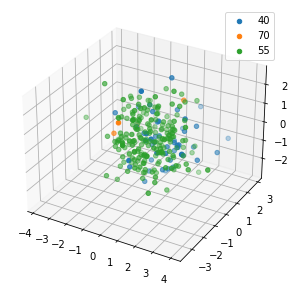

In [73]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

for age in [features.age.values.min(), features.age.values.max(), int(features.age.values.mean())]:
    lda_proj_age = lda_sklearn_age_proj[features.age.values == age]
    ax.scatter(lda_proj_age[:, 0], lda_proj_age[:, 1], lda_proj_age[:, 2], label=age)

plt.legend()
plt.show()

We can see that with either age or sex we can find a linear separation boundary for this data in a relatively low latent space.

How does this change when we want to subcategorised by multiple classes?

#### Age and Sex

In [99]:
age_sex_pairs = features[['age', 'sex']].values.tolist()
multi_classes = {}
# Main difference between this and DeepSCM, is that we are assuming
#  each (Data, class) pair is IID. We don't consider any dependencies.
classes = []
i = 0
for pair in age_sex_pairs:
    pair = tuple(pair)
    if pair in multi_classes:
        classes.append(multi_classes[pair])
    else:
        classes.append(i)
        multi_classes[pair] = i
        i += 1

In [101]:
lda_sklearn_tupleclass = LinearDiscriminantAnalysis()
lda_sklearn_tupleclass.fit(proj_meshes, classes)
lda_sklearn_tupleclass_proj = lda_sklearn_tupleclass.transform(proj_meshes)

In [102]:
lda_sklearn_tupleclass.explained_variance_ratio_.cumsum()

array([0.55050358, 0.7296449 , 0.7552315 , 0.77437909, 0.79215996,
       0.80980922, 0.82552919, 0.84037159, 0.85349345, 0.86499437,
       0.87598484, 0.88630493, 0.89566564, 0.90466427, 0.91293769,
       0.92088708, 0.92866525, 0.93620232, 0.94259745, 0.94865721,
       0.95440495, 0.95916158, 0.96369956, 0.96785453, 0.97181981,
       0.97531378, 0.97861257, 0.98156593, 0.98432521, 0.98674666,
       0.98897887, 0.99097012, 0.99290352, 0.99469954, 0.99599711,
       0.99711542, 0.99807554, 0.99892264, 0.99952453, 1.        ])

We need more modes with multiple features than we do with a single feature. There are more modes in the data. Highly multimodal dataset, hence more modes are needed to preserve a sufficient amount of variance.

How can we reduce the dimensionality of the subspace we project into?

Some thoughts - graph specific preprocess and non-linear projection.
- kernel LDA - nonlinear LDA?
- KPCA + LDA or KPCA + KLDA <-- projecting into latent manifolds via a nonlinear projections
- spectral clustering + PCA + LDA
- spectral clustering + PCA + KLDA

### Spectral Clustering

In [103]:
## Kernel LDA - nonlinear LDA
## Compare no. of modes required with LDA on mesh shape vs LDA on PCA outputs

### Interactive Plots

In [ ]:
# !pip install ipyvolume

In [ ]:
# %%bash
# jupyter nbextension enable --sys-prefix --py pythreejs

In [ ]:
# from ipywidgets import interact, fixed
# import ipyvolume as ipv

In [ ]:
# s = 1/2**0.5
# # 4 vertices for the tetrahedron
# x = np.array([1.,  -1, 0,  0])
# y = np.array([0,   0, 1., -1])
# z = np.array([-s, -s, s,  s])
# # and 4 surfaces (triangles), where the number refer to the vertex index
# triangles = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1,3,2)]

# ipv.figure()
# # we draw the tetrahedron
# mesh = ipv.plot_trisurf(x, y, z, triangles=triangles, color='orange')
# # and also mark the vertices
# ipv.scatter(x, y, z, marker='sphere', color='blue')
# ipv.xyzlim(-2, 2)
# ipv.show()

At mode 10 and onwards, we begin to see spikes on the surface mesh. This suggests that the true brain surface does consist of latent spikes, which when averaged out, create the smooth surface we expect. It is posssible, that large weights in the K learned matrices in the ChebConv early on in training could assign more importance to spiky eigenmeshes, resulting in the spikes early on in training.



- Shape modes of different ages and sexes, LDA? or just PCA shape models on different filters?
- interactive plot
- identify names for parts of the brain stem and hippocampus and write short description about how they are changing
- Calculate explained variance <-- determine how many modes make up explained variance of approx 90% and identify which parts of the brain they belong to.
- LDA - project each datapoints into 2D space after LDA. Then decide how they are being clustered.
- Do shape modelling with LDA to determine what the defining modes are in each age group and gender.